# ***Rekated libraries and packages invoking***

In [ ]:
!pip install tqdm
!pip install langdetect
!pip install pyLDAvis

     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=97c6d1d34aec2456646443da6f25bc45bfd30ea3bf9ee25c69c19e0cb135d2e5
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 16.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=3004e5698b5f43a0652a40a424bcf113d59ce8384ffa0a461e59ea3352cae831
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=f43376168f48ab8463c0bf03ccd3cd6649ef01068bb44cb84da294cd92c6c8a1
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
from zipfile import ZipFile
import json
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import datetime
import spacy, gensim
import sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
nltk.download('vader_lexicon')
tqdm.pandas()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# ***Data gatharing from the database***



In [ ]:
! wget https://yazanshpublic.s3-ap-southeast-1.amazonaws.com/data.zip

--2020-06-07 10:37:56--  https://yazanshpublic.s3-ap-southeast-1.amazonaws.com/data.zip
Resolving yazanshpublic.s3-ap-southeast-1.amazonaws.com (yazanshpublic.s3-ap-southeast-1.amazonaws.com)... 52.219.132.67
Connecting to yazanshpublic.s3-ap-southeast-1.amazonaws.com (yazanshpublic.s3-ap-southeast-1.amazonaws.com)|52.219.132.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288040178 (275M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 274.70M  13.6MB/s    in 22s     

2020-06-07 10:38:19 (12.6 MB/s) - ‘data.zip’ saved [288040178/288040178]



In [ ]:
with ZipFile('/content/data.zip', 'r') as zip:
  zip.extractall('/content/')
  zip.close()

In [ ]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [ ]:
data = pd.DataFrame(data)
data

,_id,usernameTweet,ID,location,text,url,nbr_retweet,nbr_favorite,nbr_reply,datetime,is_reply,is_retweet,user_id,hashtags,mentions,clean_text,stemmed_clean,polarity,stemmed_polarity,has_media,medias
0,{'$oid': '5ebc5f53a0ed7ff9f0ba6e40'},jeffrsmall,1255648044416196610,usa,"So this morning, I walked past the youngest, d...",/jeffrsmall/status/1255648044416196610,1,1,0,2020-04-29 23:59:57,False,False,14590019,[],[],morning walked past youngest doodling whatcha ...,morn walk past youngest doodl whatcha draw ask...,0.4939,0.4939,NaN,NaN
1,{'$oid': '5ebc5f53a0ed7ff9f0ba6e41'},willaymerich,1255648035608109057,usa,More work and this new reusable mask... Makes ...,/willaymerich/status/1255648035608109057,0,3,1,2020-04-29 23:59:55,False,False,15018422,"[coffee, stayhome, covid]",[],work new reusable mask makes drinking pain ass...,work new reusabl mask make drink pain ass sick...,-0.8750,-0.8750,NaN,NaN
2,{'$oid': '5ebc5f53a0ed7ff9f0ba6e42'},PATRICIAMEEHA17,1255648005597933568,usa,THE IDIOCY OF THE ENABLERS OF THE RACIST ILLER...,/PATRICIAMEEHA17/status/1255648005597933568,0,1,0,2020-04-29 23:59:48,False,False,849410927158054916,[topbuzz],"[funder, JaneneHague, dutch163]",idiocy enablers racist illerate mentally ill i...,idioci enabl racist iller mental ill imbecil p...,-0.8750,-0.8860,True,[https://t.co/77psQ4RoPe]
3,{'$oid': '5ebc5f53a0ed7ff9f0ba6e43'},hannahkhorick,1255647984341180417,usa,Conaway: “it looks and appears as if we did ov...,/hannahkhorick/status/1255647984341180417,1,4,1,2020-04-29 23:59:42,False,False,294868862,[],[],conaway looks appears overact coronavirus form...,conaway look appear overact coronaviru form fl...,-0.0516,-0.8860,NaN,NaN
4,{'$oid': '5ebc5f53a0ed7ff9f0ba6e44'},moderate2severe,1255647983753887752,usa,How many shell LLC’s have your kids and Javank...,/moderate2severe/status/1255647983753887752,1,2,0,2020-04-29 23:59:42,False,False,57402193,"[coronavirus, askagbarr]",[],many shell llcs kids javanka set profit,mani shell llc kid javanka set profit,0.4404,0.4404,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385464,{'$oid': '5ec209b7972b4e4af2521b3d'},JGHester350,1255597312623198209,usa,"Well heck, he was just blowing off some lockd...",/JGHester350/status/1255597312623198209,0,0,0,2020-04-29 20:38:21,False,False,909845437674266628,[],[],well heck blowing lockdown steam nothing mopar,well heck blow lockdown steam noth mopar,0.2732,0.2732,True,[https://t.co/XV5UHlI7n1]
1385465,{'$oid': '5ec209ce972b4e4af2521b3e'},87punto3,1255595227097767937,usa,# FelizMiércoles | Escuchas: \n\n03PM #LaC...,/87punto3/status/1255595227097767937,0,0,0,2020-04-29 20:30:04,False,False,110045055,"[lacorneta, mesientosúper, duroyalacabeza, cov...",[],felizmiércoles escuchas pm pm pm pm conferenci...,felizmiércol escucha pm pm pm pm conferencia p...,0.0000,0.0000,True,[https://t.co/O3UTWUCgtm]
1385466,{'$oid': '5ec20a13972b4e4af2521b3f'},Heroic_Studios,1255588454949203968,usa,"Isn't it funny that during this pandemic , le...",/Heroic_Studios/status/1255588454949203968,2,13,2,2020-04-29 20:03:10,False,False,4709494393,[],[Sinatra_Says],isnt funny pandemic leftist suddenly okay gove...,isnt funni pandem leftist suddenli okay govern...,-0.4427,-0.0541,NaN,NaN
1385467,{'$oid': '5ec20a32972b4e4af2521b40'},rezazazdeh,1255585348182310914,usa,"No covid19 and no mask on anybody, thx god",/rezazazdeh/status/1255585348182310914,0,0,1,2020-04-29 19:50:49,True,False,170376661,[],[],covid mask anybody thx god,covid mask anybodi thx god,0.5574,0.5574,NaN,NaN


In [ ]:
 data = data[['text','datetime','hashtags']]

# ***Data cleaning phase***



In [ ]:
# hashtags and mentions extraction and cleaning function
def parse_hashtags_mentions(text):
    hashtags = re.findall('#\s?\w+', text)
    hashtags = [hashtag[1:] for hashtag in hashtags]
    mentions = re.findall("@\s?\w+", text)
    mentions = [mention[1:] for mention in mentions]
    text = clean_text = re.sub('@\s?\w+','',text)
    text = clean_text = re.sub('#\s?\w+','',text)
    words = text.split(" ")
    clean_text = " ".join([word for word in words if len(word) > 0 and not word.startswith("#") and not word.startswith("@") ])
    clean_text = "".join(re.findall("[\w\s]", clean_text))
    clean_text = re.sub("\s{2,}", " ", clean_text)
    return clean_text, hashtags, mentions

In [ ]:
# Text cleaning function
def clean_text(text:str) -> str:
    text, _, _  = parse_hashtags_mentions(text)
    image_clean = re.sub("pic.[\w/.]+", "", text)
    punctionation_clean = re.sub("""[!?.'"-]""", "", image_clean)
    numbers_clean = re.sub("\d", "", punctionation_clean)
    skip_clean = re.sub("\\n|\\t", " ", numbers_clean)
    link_clean = re.sub("https.+", "", skip_clean)
    underscore_clean = re.sub('_','',link_clean)
    return underscore_clean

In [ ]:
# Stop words cleaning function
def clean_stopwords(text:str) -> str:
    text =text.lower()
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
                  'ourselves', 'you', "you're", "you've", "you'll",
                  "you'd", 'your', 'yours', 'yourself', 'yourselves', 
                  'he', 'him', 'his', 'himself', 'she', "she's", 'her',
                  'hers', 'herself', 'it', "it's", 'its','itself','they',
                  'them', 'their', 'theirs', 'themselves', 'what', 'which',
                  'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                  'am', 'is', 'are', 'was', 'were', 'be','been','being','have',
                  'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a','an',
                  'the', 'and', 'but', 'if', 'or', 'because', 'as','until','while',
                  'of', 'at', 'by','for', 'with', 'about','between','into','through',
                  'during', 'before', 'after', 'above','below','to','from','up','down',
                  'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',  'then',
                  'once', 'here', 'there', 'when', 'where', 'why','how','all','any','both',
                  'each', 'other', 'such', 'only', 'own', 'same','s','t','can','will','just', 
                  'should', "should've", 'now', 'd',  'll',  'm', 'o', 're', 've', 'y', 'than',]
    tokens = text.split(" ")
    clean = [token for token in tokens if token not in stop_words]
    return " ".join(clean).lower()

In [ ]:
# Tweets stemming function
def stem_tweet(text:str) -> str:
    stemmer = PorterStemmer()
    tokens = text.split(" ")
    stemmed = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed)


In [ ]:
# All cleaning operations function
def process_all_text(text:str)->str:
    clean = clean_stopwords(text)
    return clean_text(clean)

In [ ]:
# Polarity calculation function
def get_polarity(text:str) -> float:
    analyzer = SentimentIntensityAnalyzer()
    results = analyzer.polarity_scores(text)
    return results.get("compound")

In [ ]:
# Labels assinment function
def get_label(x:float) -> str:
    if   x > 0.05:
      return 'positive'
    elif x < -.05:
      return 'nigative'
    else:
      return 'neutral'

In [ ]:
#  Language detection function
def detect_lang(text:str) -> str:
  lang = text
  try:
    lang = detect(text)
  except LangDetectException:
    return 'None'
  return lang

In [ ]:
# Tweet length extraction function
def twt_len(text: str) -> int:
  return len(text.split())

In [ ]:
# Apply Cleaning
data['clean_text']=data['text'].progress_apply(lambda x: process_all_text(x))

In [ ]:
# Apply stemming
data['clean_stemmed']=data['clean_text'].progress_apply(lambda x: stem_tweet(x))

In [ ]:
# Calculate polarity
data['polarity']=data['clean_stemmed'].progress_apply(lambda x: get_polarity(x))

In [ ]:
# Extract Label
data['label']=data['polarity'].progress_apply(lambda x: get_label(x))

In [ ]:
# Tweet language detection
data['language']=data['clean_text'].progress_apply(lambda x: detect_lang(x))

In [ ]:
# Tweet Length Extraction
data['length']=data['clean_stemmed'].progress_apply(lambda x: twt_len(x))

In [ ]:
# Non-English tweets removal 
data = data[data.language == 'en']

In [ ]:
# Short tweets removal
data = data[data.length > 3]

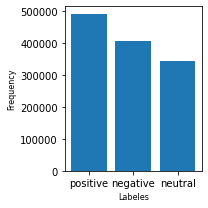

In [ ]:
# Labels distribution 
label_dist={'positive':len(data.loc[data.label =='positive']),
               'negative':len(data.loc[data.label =='nigative']),
               'neutral':len(data.loc[data.label =='neutral'])
               }
font = {'family': 'Times New Roman',
        'color':  'k',
        'weight': 'normal',
        'size':8
        }
plt.figure(figsize=(3,3))
plt.bar(label_dist.keys(),label_dist.values(),)
plt.xlabel('Labeles',fontdict=font)
plt.ylabel('Frequency',fontdict=font)
plt.tight_layout()
plt.savefig('label_dist.jpg',dpi=600)

In [ ]:
label_dist

{'negative': 406965, 'neutral': 343977, 'positive': 489677}

In [ ]:
# Data sorting by date
data = data.sort_values(by='datetime')
data.reset_index(inplace=True)
data.drop(['index'],axis=1,inplace=True)

In [ ]:
# Month extraction
data['month'] = pd.DatetimeIndex(data['datetime']).month

In [ ]:
# Data splitting based on month
feb_tweets = data[data.month == 2]
mar_tweets = data[data.month == 3]
apr_tweets = data[data.month == 4]

# ***Data Analysis Phase***

In [ ]:
with ZipFile('/content/drive/My Drive/final_analytics/feb (1).zip', 'r') as zip:
  zip.extractall('/content/')

with ZipFile('/content/drive/My Drive/final_analytics/mar (1).zip', 'r') as zip:
  zip.extractall('/content/')

with ZipFile('/content/drive/My Drive/final_analytics/apr (1).zip', 'r') as zip:
  zip.extractall('/content/')

In [ ]:
feb_tweets = pd.read_pickle('/content/content/feb.pkl')
mar_tweets = pd.read_pickle('/content/content/mar.pkl')
apr_tweets = pd.read_pickle('/content/content/apr.pkl')

In [ ]:
# Font Specifications
font = {'family': 'Times New Roman',
        'color':  'k',
        'weight': 'normal',
        'size':8
        }

In [ ]:
# COVID -19 Confirmed Cases 1/Feb. - 29/Apr.

feb_days = ['{}-feb'.format(x) for x in range(1,30)]
            
feb_cases = [1, 0, 3, 0, 0, 0, 0, 0, 0,0, 1, 0,
             1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 36,
             0, 6, 1, 2, 8]

feb_death = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 1]

feb_rec = [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
           0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
           0, 1, 0]

mar_days = ['{}-Mar'.format(x) for x in range(1,32)]

mar_cases = [6, 24, 20, 31, 70, 48, 136, 116, 69, 374, 323, 382, 514, 548,
             807, 1125, 1776, 1344, 5967, 5526, 6326, 7680, 10582, 10063,
             11919, 17992, 18126, 19824, 19124, 21237, 26025]

mar_death = [0, 5, 1, 4, 1, 2, 3, 4, 1, 6, 8, 6, 8, 10, 14, 26, 34, 31, 94,
             91, 92, 145, 199, 225, 309, 406, 543, 475, 676, 776, 1171]

mar_rec = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 5, 0, 88, 16, 26, 29,
           2, 0, 170, 13, 320, 188, 203, 1593, 2979, 1380]

apr_days = ['{}-Apr'.format(x) for x in range(1,30)]

apr_cases = [25430, 30406, 31790, 33229, 27775, 29515, 30804, 31533, 34673, 33519, 29930,
             28537, 25311, 27046, 29004, 31307, 32081, 32528, 26219, 25899, 27157, 28486,
             28819, 36188, 32796, 27631, 22412, 24385, 27327]

apr_death = [1144, 1427, 1322, 1610, 1505, 1519, 2297, 2079, 2018, 2069, 2009, 1720, 1784,
             2392, 2498, 2084, 2584, 2347, 1170, 1741, 2400, 2326, 2312, 1769, 2262, 1126,
             1338, 2136, 2612]

apr_rec = [1450, 527, 706, 4945, 2796, 2133, 2182, 1796, 1851, 3380, 2480, 1718, 10494,
           4281, 4333, 2607, 3842, 6295, 5497, 1992, 2875, 2162, 2837, 18876, 1293, 6616,
           4436, 4512, 4784]

In [ ]:
feb_tweets['day'] = pd.DatetimeIndex(feb_tweets['datetime']).day
mar_tweets['day'] = pd.DatetimeIndex(mar_tweets['datetime']).day
apr_tweets['day'] = pd.DatetimeIndex(apr_tweets['datetime']).day

In [ ]:
# Sentimet frequency per month extraction
feb_freq = list(feb_tweets.groupby(['label','day'])['day'].count().to_dict().values())
mar_freq = list(mar_tweets.groupby(['label','day'])['day'].count().to_dict().values())
apr_freq = list(apr_tweets.groupby(['label','day'])['day'].count().to_dict().values())

feb_nuet = feb_freq[0:29]
feb_neg = feb_freq[29:58]
feb_pos = feb_freq[58:]

mar_nuet = mar_freq[0:31]
mar_neg = mar_freq[31:62]
mar_pos = mar_freq[62:]

apr_nuet = apr_freq[0:29]
apr_neg = apr_freq[29:58]
apr_pos = apr_freq[58:]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


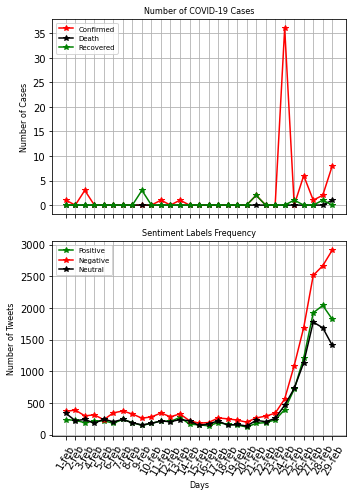

In [ ]:
# Tweets sentiment associated with number of COVID-19 cases in February. 
fig = plt.figure(figsize=(5,7))
sub1 = fig.add_subplot(2,1,1)
sub1.plot(feb_days,feb_cases,'r-*',
          feb_days,feb_death,'k-*',
          feb_days,feb_rec,'g-*')
sub1.set_xticklabels(())
sub1.set_title("Number of COVID-19 Cases",loc = 'center',fontdict=font)
sub1.set_ylabel('Number of Cases',fontdict=font)
sub1.legend(['Confirmed','Death','Recovered'],loc ='upper left',prop={'size': 7})
sub1.grid()

sub2 = fig.add_subplot(2,1,2)
sub2.plot(feb_days,feb_pos,'g-*',
          feb_days,feb_neg,'r-*',
          feb_days,feb_nuet,'k-*'
          )  
sub2.set_xticklabels(feb_days, rotation=60)
sub2.set_title("Sentiment Labels Frequency",loc = 'center',fontdict=font)  
sub2.set_ylabel('Number of Tweets',fontdict=font)
sub2.set_xlabel('Days',fontdict=font)  
sub2.legend(['Positive','Negative','Neutral'],loc ='upper left',prop={'size': 7})
sub2.grid()

plt.tight_layout()
plt.savefig('feb_sent.jpg',dpi =600)
plt.show()


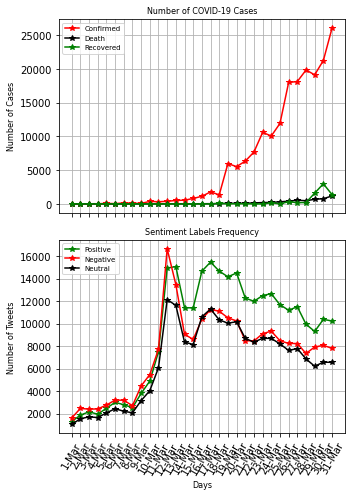

In [ ]:
# Tweets sentiment associated with number of COVID-19 cases in March. 
fig = plt.figure(figsize=(5,7))
sub1 = fig.add_subplot(2,1,1)
sub1.plot(mar_days,mar_cases,'r-*',
          mar_days,mar_death,'k-*',
          mar_days,mar_rec,'g-*')
sub1.set_xticklabels(())
sub1.set_title("Number of COVID-19 Cases",loc = 'center',fontdict=font)
sub1.set_ylabel('Number of Cases',fontdict=font)
sub1.legend(['Confirmed','Death','Recovered'],loc ='upper left',prop={'size': 7})
sub1.grid()

sub2 = fig.add_subplot(2,1,2)
sub2.plot(mar_days,mar_pos,'g-*',
          mar_days,mar_neg,'r-*',
          mar_days,mar_nuet,'k-*'
          )  
sub2.set_xticklabels(mar_days, rotation=60)
sub2.set_title("Sentiment Labels Frequency",loc = 'center',fontdict=font)  
sub2.set_ylabel('Number of Tweets',fontdict=font)
sub2.set_xlabel('Days',fontdict=font)  
sub2.legend(['Positive','Negative','Neutral'],loc ='upper left',prop={'size': 7})
sub2.grid()

plt.tight_layout()
plt.savefig('mar_sent.jpg',dpi =600)
plt.show()


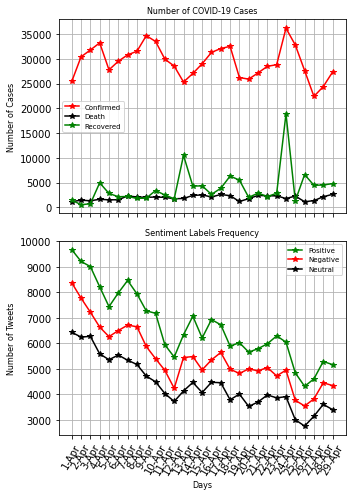

In [ ]:
# Tweets sentiment associated with number of COVID-19 cases in April. 
fig = plt.figure(figsize=(5,7))
sub1 = fig.add_subplot(2,1,1)
sub1.plot(apr_days,apr_cases,'r-*',
          apr_days,apr_death,'k-*',
          apr_days,apr_rec,'g-*')
sub1.set_xticklabels((), rotation=45)
sub1.set_title("Number of COVID-19 Cases",loc = 'center',fontdict=font)
sub1.set_ylabel('Number of Cases',fontdict=font)
sub1.legend(['Confirmed','Death','Recovered'],loc ='center left',prop={'size': 7} )
sub1.grid()

sub2 = fig.add_subplot(2,1,2)
sub2.plot(apr_days,apr_pos,'g-*',
          apr_days,apr_neg,'r-*',
          apr_days,apr_nuet,'k-*'
          )  
sub2.set_xticklabels(apr_days, rotation=60)
sub2.set_title("",loc = 'center',fontdict=font)
sub2.set_title("Sentiment Labels Frequency",loc = 'center',fontdict=font)  
sub2.set_ylabel('Number of Tweets',fontdict=font)
sub2.set_xlabel('Days',fontdict=font)   
sub2.legend(['Positive','Negative','Neutral'],loc ='upper right',prop={'size': 7})
sub2.grid()

plt.tight_layout()
plt.savefig('apr_sent.jpg',dpi =600)
plt.show()

In [ ]:
# Data splitting for LDA purposes.
feb_pos = feb_tweets[feb_tweets.label == 'positive']
feb_neg = feb_tweets[feb_tweets.label == 'nigative']
mar_pos = mar_tweets[mar_tweets.label == 'positive']
mar_neg = mar_tweets[mar_tweets.label == 'nigative']
apr_pos = apr_tweets[apr_tweets.label == 'positive']
apr_neg = apr_tweets[apr_tweets.label == 'nigative']

In [ ]:
# TF-IDF vectorizer instanciation
vectorizer_fp = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

vectorizer_fn = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

vectorizer_mp = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

vectorizer_mn = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

vectorizer_ap = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

vectorizer_an = TfidfVectorizer(analyzer='word',       
                             min_df = 10,
                             max_df = 0.9,                        
                             stop_words='english',             
                             token_pattern='[a-zA-Z0-9]{3,}',           
                            )

In [ ]:
# TF-IDF vectrorizer fitting
feb_pos_vec = vectorizer_fp.fit_transform(list(feb_pos['clean_stemmed']))
feb_neg_vec = vectorizer_fn.fit_transform(list(feb_neg['clean_stemmed']))
mar_pos_vec = vectorizer_mp.fit_transform(list(mar_pos['clean_stemmed']))
mar_neg_vec = vectorizer_mn.fit_transform(list(mar_neg['clean_stemmed']))
apr_pos_vec = vectorizer_ap.fit_transform(list(apr_pos['clean_stemmed']))
apr_neg_vec = vectorizer_an.fit_transform(list(apr_neg['clean_stemmed']))

In [ ]:
# LDA model instanciation
lda_model_fp = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

lda_model_fn = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

lda_model_mp = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

lda_model_mn = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

lda_model_ap = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

lda_model_an = LatentDirichletAllocation(n_components=4,            
                                      max_iter=20,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1,               
                                     )

In [ ]:
# LDA model fitting
feb_pos_tm = lda_model_fp.fit_transform(feb_pos_vec)
print('complete')
feb_neg_tm = lda_model_fn.fit_transform(feb_neg_vec)
print('complete')
mar_pos_tm = lda_model_mp.fit_transform(mar_pos_vec)
print('complete')
mar_neg_tm = lda_model_mn.fit_transform(mar_neg_vec)
print('complete')
apr_pos_tm = lda_model_ap.fit_transform(apr_pos_vec)
print('complete')
apr_neg_tm = lda_model_an.fit_transform(apr_neg_vec)
print('complete')

complete
complete
complete
complete
complete
complete


In [ ]:
# Topic dominancy extraction

# Dominant topic color specification function
def color_green(val):
    color = 'green' if val > 0.4 else 'black'
    return 'color: {col}'.format(col=color)

# Dominant topic font style specification function
def make_bold(val):
    weight = 700 if val > .4 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Topic dominancy extraction function
def topic_dominancy(lda_output: np.ndarray) -> pd.DataFrame:
  topicnames = ["Topic" + str(i) for i in range(len(lda_output[0]))]
  docnames = ["tweet" + str(i) for i in range(len(lda_output))]
  df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)
  dominant_topic = np.argmax(df_document_topic.values, axis=1)
  df_document_topic['dominant_topic'] = dominant_topic
  #df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
  return df_document_topic

In [ ]:
feb_pos_tm_Dom = topic_dominancy(feb_pos_tm)
feb_pos_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.07,0.79,0.07,0.07,1
tweet1,0.48,0.07,0.07,0.39,0
tweet2,0.73,0.09,0.09,0.09,0
tweet3,0.08,0.08,0.77,0.08,2
tweet4,0.23,0.07,0.62,0.07,2
...,...,...,...,...,...
tweet12480,0.07,0.43,0.24,0.26,1
tweet12481,0.07,0.07,0.47,0.39,2
tweet12482,0.08,0.19,0.54,0.19,2
tweet12483,0.09,0.10,0.09,0.71,3


In [ ]:
feb_neg_tm_Dom = topic_dominancy(feb_neg_tm)
feb_neg_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.06,0.06,0.82,0.06,2
tweet1,0.06,0.06,0.82,0.06,2
tweet2,0.05,0.53,0.38,0.05,1
tweet3,0.77,0.08,0.08,0.08,0
tweet4,0.11,0.11,0.10,0.68,3
...,...,...,...,...,...
tweet17967,0.07,0.07,0.71,0.15,2
tweet17968,0.07,0.07,0.71,0.15,2
tweet17969,0.22,0.08,0.62,0.08,2
tweet17970,0.49,0.23,0.05,0.22,0


In [ ]:
mar_pos_tm_Dom = topic_dominancy(mar_pos_tm)
mar_pos_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.22,0.06,0.56,0.16,2
tweet1,0.07,0.07,0.07,0.79,3
tweet2,0.62,0.05,0.10,0.23,0
tweet3,0.33,0.27,0.07,0.33,0
tweet4,0.26,0.63,0.06,0.06,1
...,...,...,...,...,...
tweet284208,0.09,0.39,0.44,0.08,2
tweet284209,0.11,0.05,0.12,0.71,3
tweet284210,0.06,0.13,0.40,0.41,3
tweet284211,0.28,0.53,0.09,0.10,1


In [ ]:
mar_neg_tm_Dom = topic_dominancy(mar_neg_tm)
mar_neg_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.51,0.06,0.05,0.38,0
tweet1,0.63,0.24,0.06,0.07,0
tweet2,0.08,0.25,0.58,0.08,2
tweet3,0.73,0.07,0.14,0.06,0
tweet4,0.15,0.61,0.17,0.07,1
...,...,...,...,...,...
tweet231164,0.08,0.08,0.08,0.76,3
tweet231165,0.06,0.23,0.19,0.52,3
tweet231166,0.35,0.07,0.33,0.25,0
tweet231167,0.07,0.70,0.17,0.07,1


In [ ]:
apr_pos_tm_Dom = topic_dominancy(apr_pos_tm)
apr_pos_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.21,0.14,0.60,0.05,2
tweet1,0.06,0.07,0.07,0.80,3
tweet2,0.09,0.09,0.09,0.73,3
tweet3,0.19,0.06,0.50,0.25,2
tweet4,0.71,0.16,0.07,0.07,0
...,...,...,...,...,...
tweet192974,0.33,0.50,0.05,0.13,1
tweet192975,0.36,0.06,0.53,0.06,2
tweet192976,0.28,0.57,0.07,0.07,1
tweet192977,0.66,0.22,0.06,0.06,0


In [ ]:
apr_neg_tm_Dom = topic_dominancy(apr_neg_tm)
apr_neg_tm_Dom

,Topic0,Topic1,Topic2,Topic3,dominant_topic
tweet0,0.06,0.05,0.23,0.66,3
tweet1,0.05,0.05,0.61,0.29,2
tweet2,0.07,0.07,0.79,0.07,2
tweet3,0.06,0.06,0.82,0.06,2
tweet4,0.08,0.71,0.15,0.05,1
...,...,...,...,...,...
tweet157819,0.28,0.07,0.57,0.07,2
tweet157820,0.27,0.21,0.46,0.06,2
tweet157821,0.26,0.12,0.14,0.48,3
tweet157822,0.05,0.24,0.05,0.66,3


In [ ]:
pyLDAvis.enable_notebook()
panel1 = pyLDAvis.sklearn.prepare(lda_model_fp, feb_pos_vec, vectorizer_fp, mds='tsne',)
panel1

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  27.750825
1        1.782994 -295.079681       2        1  27.485772
0      220.811432 -343.832123       3        1  24.752038
2       50.533993  -76.050934       4        1  20.011364, topic_info=       Term        Freq       Total Category  logprob  loglift
264    case  172.000000  172.000000  Default  30.0000  30.0000
1913  trump  233.000000  233.000000  Default  29.0000  29.0000
835    hand  156.000000  156.000000  Default  28.0000  28.0000
1325   penc  101.000000  101.000000  Default  27.0000  27.0000
1834   test  104.000000  104.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
1327  peopl   49.991375  211.680348   Topic4  -5.0128   0.1656
796    good   46.004857  173.598881   Topic4  -5.0959   0.2809
1957   viru   41.052809  128.999152   Topic4  -5.2098   0.4639
1758   stop   37.746142   80.700803   Topic4  -5.2938   0.8490
1913  trump   37.565803  233.545346   Topic4  -5.2986  -0.2184

[240 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
26        2  0.038227  administr
26        3  0.955687  administr
35        1  0.931884     affect
35        2  0.077657     affect
51        4  0.957576       aint
...     ...       ...        ...
2027      3  0.207376       work
2027      4  0.088875       work
2035      3  0.972630    wouldnt
2041      1  0.980578      wuhan
2046      2  0.964955       yeah

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [ ]:
panel1.topic_info.sort_values(['Category','Freq']).head(30)

,Term,Freq,Total,Category,logprob,loglift
1966,wait,46.0,46.0,Default,2.0,2.0
996,ive,46.0,46.0,Default,1.0,1.0
440,cruis,49.0,49.0,Default,9.0,9.0
880,hoax,54.0,54.0,Default,12.0,12.0
1385,pray,60.0,60.0,Default,10.0,10.0
1936,updat,60.0,60.0,Default,3.0,3.0
1319,patient,61.0,61.0,Default,6.0,6.0
1527,report,61.0,61.0,Default,5.0,5.0
1980,watch,61.0,61.0,Default,4.0,4.0
367,confirm,62.0,62.0,Default,8.0,8.0


In [ ]:
pyLDAvis.enable_notebook()
panel2 = pyLDAvis.sklearn.prepare(lda_model_fn, feb_neg_vec, vectorizer_fn, mds='tsne')
panel2

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  28.837085
2        1.782994 -295.079681       2        1  26.464834
1      220.811432 -343.832123       3        1  23.652801
3       50.533993  -76.050934       4        1  21.045280, topic_info=        Term        Freq       Total Category  logprob  loglift
552    death  354.000000  354.000000  Default  30.0000  30.0000
316     case  230.000000  230.000000  Default  29.0000  29.0000
2283   trump  434.000000  434.000000  Default  28.0000  28.0000
1810  report  174.000000  174.000000  Default  27.0000  27.0000
1049    hoax  184.000000  184.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
2342    veri   52.521982  101.523125   Topic4  -5.3901   0.8994
1281    like   54.946511  198.697994   Topic4  -5.3450   0.2731
358    china   53.195347  284.017501   Topic4  -5.3774  -0.1166
1214    kill   52.413728  206.771560   Topic4  -5.3922   0.1860
2063  spread   51.537912  243.682351   Topic4  -5.4090   0.0049

[235 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
26        3  0.994341  administr
34        4  0.991234     affect
73        2  0.981711       amid
156       4  0.995225       away
160       1  0.556139        bad
...     ...       ...        ...
2444      2  0.992576       wors
2446      3  0.995579      worst
2455      3  0.983262        wtf
2457      2  0.987124      wuhan
2460      1  0.989530       yall

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [ ]:
panel2.topic_info.sort_values(['Category','Freq']).head(30)

,Term,Freq,Total,Category,logprob,loglift
471,corona,85.0,85.0,Default,11.0,11.0
1278,life,85.0,85.0,Default,1.0,1.0
1005,happen,86.0,86.0,Default,8.0,8.0
1064,hospit,90.0,90.0,Default,4.0,4.0
2457,wuhan,92.0,92.0,Default,6.0,6.0
1344,mask,94.0,94.0,Default,15.0,15.0
2163,talk,96.0,96.0,Default,17.0,17.0
1514,offici,101.0,101.0,Default,10.0,10.0
2384,washington,102.0,102.0,Default,13.0,13.0
223,blame,105.0,105.0,Default,5.0,5.0


In [ ]:
pyLDAvis.enable_notebook()
panel3 = pyLDAvis.sklearn.prepare(lda_model_mp, mar_pos_vec, vectorizer_mp, mds='tsne')
panel3

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  32.886819
0        1.782994 -295.079681       2        1  24.459511
1      220.811432 -343.832123       3        1  21.833934
2       50.533993  -76.050934       4        1  20.819736, topic_info=          Term         Freq        Total Category  logprob  loglift
10222    trump  2223.000000  2223.000000  Default  30.0000  30.0000
4352      hand  2227.000000  2227.000000  Default  29.0000  29.0000
9865      test  2357.000000  2357.000000  Default  28.0000  28.0000
4454    health  1897.000000  1897.000000  Default  27.0000  27.0000
1478      case  1790.000000  1790.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
892     better   701.171840  1775.779251   Topic4  -5.5906   0.6400
8305     right   716.482299  1983.558947   Topic4  -5.5690   0.5510
2211   countri   643.723388  1222.804920   Topic4  -5.6761   0.9276
4133      good   709.933920  3342.240000   Topic4  -5.5782   0.0200
11075    world   615.260672  1813.563363   Topic4  -5.7213   0.4883

[246 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
188        2  0.998252      aint
189        3  0.999015       air
305        1  0.102443   america
305        4  0.896705   america
306        1  0.333438  american
...      ...       ...       ...
11149      3  0.206348      yall
11157      3  0.998151      yeah
11158      2  0.191924      year
11158      3  0.510236      year
11158      4  0.297582      year

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [ ]:
panel3.topic_info.sort_values(['Category','Freq']).head(30)

,Term,Freq,Total,Category,logprob,loglift
8909,sign,830.0,830.0,Default,5.0,5.0
6859,onlin,832.0,832.0,Default,4.0,4.0
4462,hear,849.0,849.0,Default,6.0,6.0
3250,enjoy,897.0,897.0,Default,8.0,8.0
3620,fight,930.0,930.0,Default,12.0,12.0
10668,video,941.0,941.0,Default,10.0,10.0
1388,cancel,948.0,948.0,Default,11.0,11.0
6877,open,1039.0,1039.0,Default,18.0,18.0
7523,posit,1139.0,1139.0,Default,2.0,2.0
7620,presid,1145.0,1145.0,Default,23.0,23.0


In [ ]:
pyLDAvis.enable_notebook()
panel4 = pyLDAvis.sklearn.prepare(lda_model_mn, mar_neg_vec, vectorizer_mn, mds='tsne')
panel4

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  34.858526
3        1.782994 -295.079681       2        1  24.338177
2      220.811432 -343.832123       3        1  21.703103
1       50.533993  -76.050934       4        1  19.100194, topic_info=          Term         Freq        Total Category  logprob  loglift
9037     trump  3278.000000  3278.000000  Default  30.0000  30.0000
2168     death  3394.000000  3394.000000  Default  29.0000  29.0000
1283      case  2409.000000  2409.000000  Default  28.0000  28.0000
7804      shit  2164.000000  2164.000000  Default  27.0000  27.0000
5069  lockdown  2293.000000  2293.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2147       day   722.615412  2450.508803   Topic4  -5.2593   0.4343
6225    pandem   849.832538  5770.830411   Topic4  -5.0971  -0.2601
3456      fuck   641.206017  2535.600336   Topic4  -5.3788   0.2806
8270     state   532.224006  1606.485335   Topic4  -5.5651   0.5507
8867     today   503.610988  1462.167542   Topic4  -5.6203   0.5896

[244 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
27        4  0.998360    absolut
103       3  0.999390  administr
142       4  0.996829        age
163       2  0.997041       aint
221       1  0.998734      allow
...     ...       ...        ...
9830      3  0.998246        wtf
9859      2  0.999507       yall
9868      1  0.543541       year
9868      4  0.455782       year
9887      4  0.998900       york

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [ ]:
panel4.topic_info.sort_values(['Category','Freq']).head(35)

,Term,Freq,Total,Category,logprob,loglift
9887,york,647.000000,647.000000,Default,1.0000,1.0000
4244,idiot,693.000000,693.000000,Default,5.0000,5.0000
2262,democrat,707.000000,707.000000,Default,2.0000,2.0000
8915,total,742.000000,742.000000,Default,9.0000,9.0000
5331,mean,768.000000,768.000000,Default,3.0000,3.0000
1447,chines,796.000000,796.000000,Default,8.0000,8.0000
859,blame,823.000000,823.000000,Default,12.0000,12.0000
4986,lie,844.000000,844.000000,Default,13.0000,13.0000
1917,counti,863.000000,863.000000,Default,14.0000,14.0000
1746,confirm,875.000000,875.000000,Default,17.0000,17.0000


In [ ]:
pyLDAvis.enable_notebook()
panel5 = pyLDAvis.sklearn.prepare(lda_model_ap, apr_pos_vec, vectorizer_ap, mds='tsne')
panel5

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  27.760348
0        1.782994 -295.079681       2        1  26.212853
2      220.811432 -343.832123       3        1  24.179854
1       50.533993  -76.050934       4        1  21.846945, topic_info=            Term         Freq        Total Category  logprob  loglift
9065       trump  1606.000000  1606.000000  Default  30.0000  30.0000
4192      hospit   950.000000   950.000000  Default  29.0000  29.0000
9788      worker  1276.000000  1276.000000  Default  28.0000  28.0000
3901        hand   943.000000   943.000000  Default  27.0000  27.0000
5129    lockdown  2085.000000  2085.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
7830       share   549.010346  1134.822586   Topic4  -5.5049   0.7950
6265      pandem   768.910510  5452.717972   Topic4  -5.1681  -0.4378
5188        love   587.825206  2062.857712   Topic4  -5.4366   0.2657
8900       today   577.126641  1784.939629   Topic4  -5.4550   0.3920
1924  coronaviru   581.942811  3901.465544   Topic4  -5.4467  -0.3816

[266 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
266       1  0.118766    america
266       2  0.054516    america
266       3  0.825521    america
267       3  0.998654   american
320       1  0.995633    announc
...     ...       ...        ...
9864      2  0.997162       yeah
9865      1  0.100233       year
9865      2  0.654149       year
9865      3  0.246185       year
9876      4  0.996744  yesterday

[378 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [ ]:
panel5.topic_info.sort_values(['Category','Freq']).head(30)

,Term,Freq,Total,Category,logprob,loglift
7929,sign,560.0,560.0,Default,1.0,1.0
3493,frontlin,561.0,561.0,Default,3.0,3.0
3858,guy,563.0,563.0,Default,4.0,4.0
4058,hero,564.0,564.0,Default,6.0,6.0
8192,special,582.0,582.0,Default,9.0,9.0
5988,nurs,619.0,619.0,Default,13.0,13.0
9443,video,633.0,633.0,Default,16.0,16.0
3995,healthcar,634.0,634.0,Default,5.0,5.0
4966,learn,690.0,690.0,Default,8.0,8.0
6772,presid,716.0,716.0,Default,19.0,19.0


In [ ]:
pyLDAvis.enable_notebook()
panel6 = pyLDAvis.sklearn.prepare(lda_model_an, apr_neg_vec, vectorizer_an, mds='tsne')
panel6

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  28.430976
3        1.782994 -295.079681       2        1  25.380708
1      220.811432 -343.832123       3        1  23.196900
0       50.533993  -76.050934       4        1  22.991415, topic_info=       Term         Freq        Total Category  logprob  loglift
1929  death  3319.000000  3319.000000  Default  30.0000  30.0000
7998  trump  2467.000000  2467.000000  Default  29.0000  29.0000
1143   case  1681.000000  1681.000000  Default  28.0000  28.0000
3069   fuck  1338.000000  1338.000000  Default  27.0000  27.0000
5150    new  1617.000000  1617.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
5258   nurs   377.507582   531.474828   Topic4  -5.7329   1.1280
7849  today   455.371923  1046.221357   Topic4  -5.5453   0.6382
1910    day   495.763191  1512.825088   Topic4  -5.4604   0.3544
6723    say   451.031429  1645.665215   Topic4  -5.5549   0.1757
3611   home   411.139846  1271.439886   Topic4  -5.6475   0.3411

[237 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9         1  0.998206        abl
68        2  0.998522     action
92        2  0.998596  administr
142       3  0.996633       agre
237       1  0.063015    america
...     ...       ...        ...
8660      2  0.426425      world
8660      3  0.112120      world
8660      4  0.225160      world
8725      1  0.997900       yall
8748      4  0.998711       york

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [ ]:
panel6.topic_info.sort_values(['Category','Freq']).head(30)

,Term,Freq,Total,Category,logprob,loglift
7861,toll,575.0,575.0,Default,1.0,1.0
1711,counti,607.0,607.0,Default,4.0,4.0
770,blame,625.0,625.0,Default,2.0,2.0
7153,social,629.0,629.0,Default,6.0,6.0
4452,lie,636.0,636.0,Default,3.0,3.0
6221,rate,645.0,645.0,Default,10.0,10.0
3902,infect,675.0,675.0,Default,5.0,5.0
7888,total,685.0,685.0,Default,14.0,14.0
8481,warn,687.0,687.0,Default,8.0,8.0
5363,open,710.0,710.0,Default,17.0,17.0


In [ ]:
# Show topic words along with frequency
def topic_words(lda_model : sklearn.decomposition._lda.LatentDirichletAllocation,
                 vectorizer : sklearn.feature_extraction.text.TfidfVectorizer) -> pd.DataFrame:
  df_topic_keywords = pd.DataFrame(lda_model.components_)
  df_topic_keywords.columns = vectorizer.get_feature_names()
  df_topic_keywords.index = ["Topic" + str(i) for i in range(lda_model.n_components)]
  return df_topic_keywords.T

In [ ]:
topic_words(lda_model_fp,vectorizer_fp)

,Topic0,Topic1,Topic2,Topic3
abc,0.254040,0.254713,4.232962,0.288444
abil,0.289774,0.263230,11.025165,0.264795
abl,0.275419,0.271399,0.277777,24.374316
aboard,0.251656,0.250392,8.235700,0.252423
abroad,0.255738,0.256592,0.256644,4.908466
...,...,...,...,...
youv,0.265152,0.258097,11.500724,0.260495
yup,0.262304,0.261132,4.334619,0.258829
zero,0.297882,5.062643,0.280506,12.171495
zombi,0.252316,0.259783,6.376082,0.252655


In [ ]:
topic_words(lda_model_fn,vectorizer_fn)

,Topic0,Topic1,Topic2,Topic3
abandon,0.274281,4.565845,0.263893,0.253388
abc,0.257360,0.262946,8.197586,0.255516
abil,0.280369,0.436452,17.023934,0.261543
abl,0.276022,20.932356,2.575766,0.274964
aboard,0.250406,0.250644,11.331330,0.250175
...,...,...,...,...
yup,0.258202,4.715239,0.255719,0.256056
zero,0.262908,0.262779,21.820467,0.262376
zika,4.140410,0.271672,0.266121,0.274908
zombi,0.269913,11.038887,0.260728,0.281513


In [ ]:
topic_words(lda_model_mp,vectorizer_mp)

,Topic0,Topic1,Topic2,Topic3
aac,0.253963,3.813686,0.252455,0.256466
aap,0.252028,0.255205,0.254891,5.084803
aaron,0.267246,0.262942,14.222297,0.267255
aarp,0.251537,0.274703,0.253943,6.471944
abandon,0.281024,0.281506,0.271181,34.977282
...,...,...,...,...
zoonot,8.895446,0.256287,0.265865,0.259578
zpack,0.262594,0.259331,0.274538,5.487303
zpak,0.250345,0.253508,24.428660,0.265298
zuckerberg,7.262423,0.262398,0.263361,0.275283


In [ ]:
topic_words(lda_model_mn,vectorizer_mn)

,Topic0,Topic1,Topic2,Topic3
aaa,0.262666,0.251447,4.693871,0.277001
aaron,0.260156,0.255686,0.268434,10.506227
abandon,56.156729,0.266475,0.274377,14.428701
abat,5.311627,0.257248,0.270491,0.258325
abbott,51.486492,0.251742,0.257882,0.252298
...,...,...,...,...
zone,66.429067,0.274255,0.265374,0.273522
zoo,0.265325,0.260701,11.169521,0.269760
zoom,70.836517,0.267920,0.262971,0.273636
zoonot,0.263471,0.253857,0.260764,5.529144


In [ ]:
topic_words(lda_model_ap,vectorizer_ap)

,Topic0,Topic1,Topic2,Topic3
aaron,14.321498,0.277856,0.262028,0.265220
aau,5.864607,0.256473,0.257401,0.260316
abandon,0.267138,0.260588,21.001062,0.270851
abat,0.256545,0.258028,0.261299,6.178491
abbey,0.268874,4.931182,0.270108,0.258337
...,...,...,...,...
zookeep,0.258654,5.417431,0.255211,0.254305
zoom,0.290274,74.553161,0.262712,157.804227
zoonot,0.256398,0.256576,0.269726,4.804512
zpak,0.252148,7.133745,0.251331,0.269738


In [ ]:
topic_words(lda_model_an,vectorizer_an)

,Topic0,Topic1,Topic2,Topic3
aaron,0.261980,0.268608,0.256288,6.314194
abandon,0.264921,53.071886,0.261471,0.269147
abbott,19.850456,0.258373,0.255245,0.259439
abc,67.964599,0.254027,0.255373,0.265302
abet,0.253699,0.254096,0.252830,5.193847
...,...,...,...,...
zone,43.410776,0.279807,0.270333,0.264095
zoo,31.470262,0.255885,0.257359,0.252607
zoom,0.258070,96.593568,0.279216,0.258783
zoonot,0.265183,5.036162,0.264510,0.263739


In [ ]:
#show the most frequent topic words 
def most_freq_topic_words(lda_model : sklearn.decomposition._lda.LatentDirichletAllocation,
                          vectorizer : sklearn.feature_extraction.text.TfidfVectorizer,
                          n_words : int) -> pd.DataFrame:
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []

    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))

    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    return df_topic_keywords.T



In [ ]:
fp = most_freq_topic_words(lda_model_fp,vectorizer_fp,20)
fp.to_csv('/content/drive/My Drive/final_analytics/fp.csv')
fp

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,coronaviru,coronaviru,coronaviru,case
Word 1,trump,like,like,coronaviru
Word 2,hand,love,market,china
Word 3,penc,covid,lol,test
Word 4,pandem,friend,corona,number
Word 5,wash,inform,pandem,health
Word 6,presid,mask,stock,covid
Word 7,better,pandem,hoax,state
Word 8,dont,lockdown,peopl,novel
Word 9,god,watch,play,infect


In [ ]:
fn = most_freq_topic_words(lda_model_fn,vectorizer_fn,20)
fn.to_csv('/content/drive/My Drive/final_analytics/fn.csv')
fn

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,coronaviru,trump,coronaviru,coronaviru
Word 1,trump,respons,death,peopl
Word 2,hoax,pandem,case,cancel
Word 3,market,coronaviru,die,flu
Word 4,pandem,fight,report,talk
Word 5,peopl,penc,china,mask
Word 6,democrat,happen,state,corona
Word 7,stock,cut,infect,dont
Word 8,say,polit,warn,world
Word 9,like,administr,confirm,everyon


In [ ]:
mp = most_freq_topic_words(lda_model_mp,vectorizer_mp,20)
mp.to_csv('/content/drive/My Drive/final_analytics/mp.csv')
mp

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,stay,coronaviru,pandem,covid
Word 1,hand,time,coronaviru,help
Word 2,coronaviru,friend,trump,test
Word 3,like,day,like,thank
Word 4,home,pandem,peopl,need
Word 5,day,lockdown,covid,health
Word 6,safe,covid,lol,coronaviru
Word 7,pandem,open,presid,case
Word 8,good,thank,say,work
Word 9,covid,like,dont,support


In [ ]:
mn = most_freq_topic_words(lda_model_mn,vectorizer_mn,20)
mn.to_csv('/content/drive/My Drive/final_analytics/mn.csv')
mn

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,covid,death,trump,coronaviru
Word 1,coronaviru,coronaviru,pandem,shit
Word 2,cancel,case,coronaviru,lockdown
Word 3,test,covid,presid,fuck
Word 4,peopl,die,respons,peopl
Word 5,pandem,new,covid,pandem
Word 6,work,number,hoax,covid
Word 7,need,damn,viru,dont
Word 8,time,peopl,stupid,yall
Word 9,flu,break,american,like


In [ ]:
ap = most_freq_topic_words(lda_model_ap,vectorizer_ap,20)
ap.to_csv('/content/drive/My Drive/final_analytics/ap.csv')
ap

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,pandem,thank,pandem,covid
Word 1,like,covid,trump,help
Word 2,lockdown,help,coronaviru,need
Word 3,day,worker,peopl,test
Word 4,stay,hospit,covid,coronaviru
Word 5,time,hand,like,pandem
Word 6,good,support,dont,busi
Word 7,covid,care,american,case
Word 8,love,pandem,want,distanc
Word 9,coronaviru,work,presid,social


In [ ]:
an = most_freq_topic_words(lda_model_an,vectorizer_an,20)
an.to_csv('/content/drive/My Drive/final_analytics/an.csv')
an

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,death,covid,pandem,trump
Word 1,covid,pandem,covid,pandem
Word 2,coronaviru,mask,fuck,coronaviru
Word 3,case,open,peopl,respons
Word 4,new,social,lockdown,american
Word 5,die,risk,dont,presid
Word 6,test,distanc,shit,covid
Word 7,number,work,coronaviru,china
Word 8,report,peopl,know,warn
Word 9,flu,public,like,peopl


In [ ]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=4, random_state=100).fit_predict(apr_pos_tm)

svd_model = TruncatedSVD(n_components=2)  
lda_output_svd = svd_model.fit_transform(apr_pos_tm)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]


print("Component's weights: \n", np.round(svd_model.components_, 2))

print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.54  0.42  0.47  0.55]
 [ 0.74 -0.02 -0.05 -0.67]]
Perc of Variance Explained: 
 [0.  0.4]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

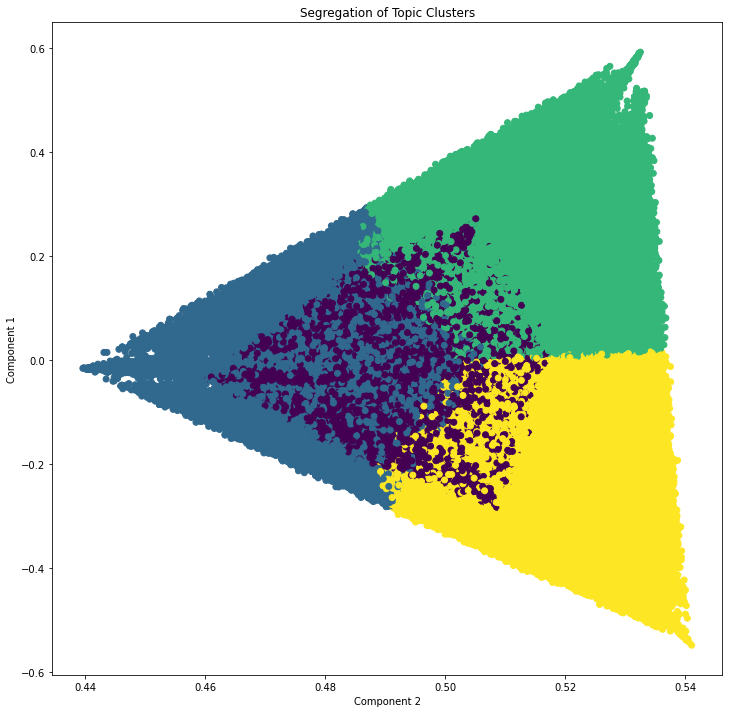

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.title("Segregation of Topic Clusters", )